In [1]:
import os
import glob
import math
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from kneed import KneeLocator
from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Part A: Graphical analysis of the dataset

In [2]:
# Use glob to return a list of pathnames for the 'sources' and the 'demand' csv files
sources_csv = glob.glob(r"sources\*.csv")
demand_csv = glob.glob(r"demand\*.csv")

# Load to dataframe the non-empty csv files and append them to a list
# src_list -> a list with all the 'sources' dataframes
src_list = []
for file in sources_csv:
    if os.stat(file).st_size != 0: # Check if file is non-empty
        df = pd.read_csv(file)
        src_list.append(df)

# dmnd_list -> a list with all the 'demand' dataframes
dmnd_list = []
for file in demand_csv:
    if os.stat(file).st_size != 0: # Check if file is non-empty
        df = pd.read_csv(file)
        dmnd_list.append(df)

In [3]:
# Merge each pair of 'sources' and 'demand' dataframes into one dataframe
# and append it to a new list (merged_list)
merged_list = []
for df1, df2 in zip(src_list, dmnd_list):
    df = pd.concat([df2, df1], axis=1)
    df.drop('Time', inplace=True, axis=1) # Drop 'Time' column
    df.columns = ['Day ahead forecast', 'Hour ahead forecast', 'Current demand', 'Solar',
                  'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro', 'Coal', 'Nuclear',
                  'Natural gas', 'Large hydro', 'Batteries', 'Imports', 'Other']
    merged_list.append(df)

In [4]:
# Create dataframe 'df_days' containing the average values of each day
df_days = pd.DataFrame(columns = ['Date', 'Day ahead forecast', 'Hour ahead forecast', 'Current demand', 'Solar',
                                  'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro', 'Coal', 'Nuclear', 
                                  'Natural gas', 'Large hydro', 'Batteries', 'Imports', 'Other'])

date = datetime.datetime(2019, 1, 1) # The start date
delta = datetime.timedelta(days=1)
index = 0
for df in merged_list:
    df_days.loc[index] = [date] + df.mean().round(2).tolist() # Insert a new row (or day) to 'df_days'
    date += delta # We move on to the next day
    index += 1 # We move on to the next row

# Create a new column called 'Total sources' with the sum of all the sources
df_days["Total sources"] = df_days.iloc[:,4:16].sum(axis=1)

df_days.head() # Take a look at the 'df_days' dataframe

,Date,Day ahead forecast,Hour ahead forecast,Current demand,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Total sources
0,2019-01-01,22098.94,21804.53,21812.47,2507.79,1426.83,988.21,380.07,211.52,221.00,13.03,2273.53,6589.80,1859.85,1.33,5475.11,0.0,21948.07
1,2019-01-02,25154.76,24021.67,24134.61,2540.55,350.12,986.46,374.85,226.66,226.36,13.18,2271.85,NaN,1881.89,-4.77,6988.87,0.0,15856.02
2,2019-01-03,24598.27,24487.00,24751.85,2573.57,423.15,986.43,340.07,229.37,200.34,13.75,2269.74,8026.52,1756.77,0.95,8099.68,0.0,24920.34
3,2019-01-04,24032.92,24128.78,24432.81,2545.80,298.84,987.02,274.33,229.12,196.13,13.95,2271.33,8032.13,1772.36,-4.38,7947.94,0.0,24564.57
4,2019-01-05,22850.93,23757.70,23862.24,511.89,926.00,985.50,281.93,227.72,189.26,12.40,2271.35,8649.96,1558.91,-6.47,8490.59,0.0,24099.04


### A.1 Check if production is above demand

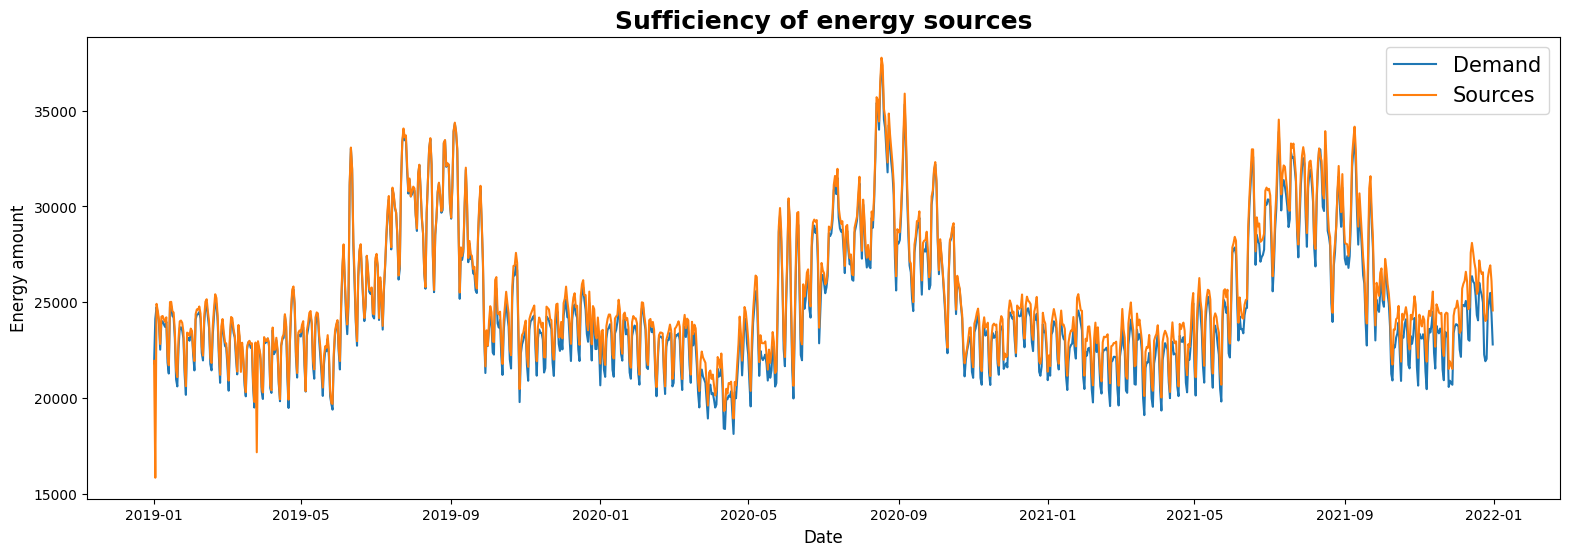

In [5]:
# Plotting 'Total sources' and 'Current demand' lines
plt.style.use('default')
figure(figsize=(19, 6))
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy amount", fontsize=12)
plt.plot(df_days["Date"], df_days["Current demand"], label = "Demand", linestyle = 'solid')
plt.plot(df_days["Date"], df_days["Total sources"], label = "Sources", linestyle = 'solid')
plt.legend(fontsize=15)
plt.title(label='Sufficiency of energy sources', weight='bold', fontsize=18)
plt.show()

### A.2 Check the connection between renewable and non-renewable sources over the days

In [6]:
# Create new columns with the sums of the renewable and non-renewable sources
df_days["NonRenewable sources"] = df_days[['Coal', 'Nuclear', 'Natural gas', 'Batteries']].sum(axis=1)
df_days["Renewable sources"] = df_days[['Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro', 'Large hydro']].sum(axis=1)

df_days.head() # Take a look at the 'df_days' dataframe

,Date,Day ahead forecast,Hour ahead forecast,Current demand,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Total sources,NonRenewable sources,Renewable sources
0,2019-01-01,22098.94,21804.53,21812.47,2507.79,1426.83,988.21,380.07,211.52,221.00,13.03,2273.53,6589.80,1859.85,1.33,5475.11,0.0,21948.07,8877.69,7595.27
1,2019-01-02,25154.76,24021.67,24134.61,2540.55,350.12,986.46,374.85,226.66,226.36,13.18,2271.85,NaN,1881.89,-4.77,6988.87,0.0,15856.02,2280.26,6586.89
2,2019-01-03,24598.27,24487.00,24751.85,2573.57,423.15,986.43,340.07,229.37,200.34,13.75,2269.74,8026.52,1756.77,0.95,8099.68,0.0,24920.34,10310.96,6509.70
3,2019-01-04,24032.92,24128.78,24432.81,2545.80,298.84,987.02,274.33,229.12,196.13,13.95,2271.33,8032.13,1772.36,-4.38,7947.94,0.0,24564.57,10313.03,6303.60
4,2019-01-05,22850.93,23757.70,23862.24,511.89,926.00,985.50,281.93,227.72,189.26,12.40,2271.35,8649.96,1558.91,-6.47,8490.59,0.0,24099.04,10927.24,4681.21


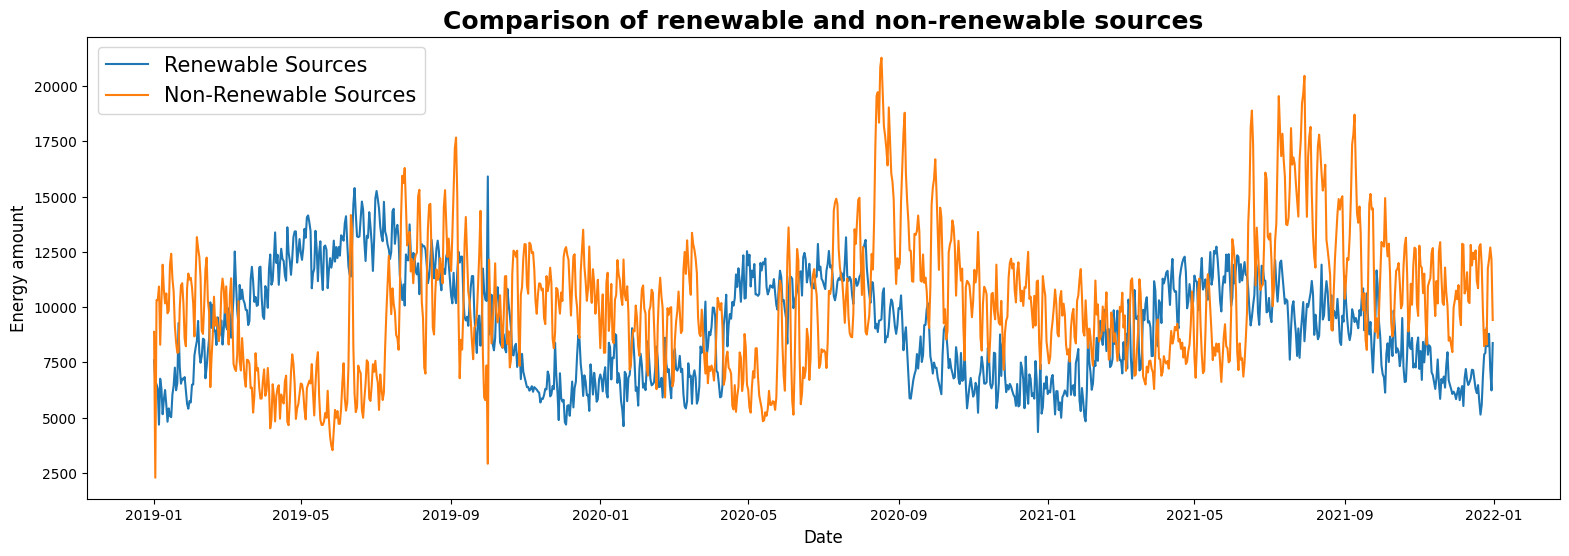

In [7]:
# Plotting 'Renewable sources' and 'NonRenewable sources' lines
figure(figsize=(19, 6))
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy amount", fontsize=12)
plt.plot(df_days["Date"], df_days["Renewable sources"], label = "Renewable Sources", linestyle = 'solid')
plt.plot(df_days["Date"], df_days["NonRenewable sources"], label = "Non-Renewable Sources", linestyle = 'solid')
plt.legend(fontsize=15)
plt.title(label='Comparison of renewable and non-renewable sources', weight='bold', fontsize=18)
plt.show()

### A.3 Check the variance of both renewable and non-renewable sources over the months

In [8]:
# Create a new column for storing the month of the corresponding 'Date'
months = []
for i in range(df_days.shape[0]):
    months.append(df_days.Date[i].month)
df_days["Month"] = months

df_days.head() # Take a look at the 'df_days' dataframe

,Date,Day ahead forecast,Hour ahead forecast,Current demand,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,...,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Total sources,NonRenewable sources,Renewable sources,Month
0,2019-01-01,22098.94,21804.53,21812.47,2507.79,1426.83,988.21,380.07,211.52,221.00,...,2273.53,6589.80,1859.85,1.33,5475.11,0.0,21948.07,8877.69,7595.27,1
1,2019-01-02,25154.76,24021.67,24134.61,2540.55,350.12,986.46,374.85,226.66,226.36,...,2271.85,NaN,1881.89,-4.77,6988.87,0.0,15856.02,2280.26,6586.89,1
2,2019-01-03,24598.27,24487.00,24751.85,2573.57,423.15,986.43,340.07,229.37,200.34,...,2269.74,8026.52,1756.77,0.95,8099.68,0.0,24920.34,10310.96,6509.70,1
3,2019-01-04,24032.92,24128.78,24432.81,2545.80,298.84,987.02,274.33,229.12,196.13,...,2271.33,8032.13,1772.36,-4.38,7947.94,0.0,24564.57,10313.03,6303.60,1
4,2019-01-05,22850.93,23757.70,23862.24,511.89,926.00,985.50,281.93,227.72,189.26,...,2271.35,8649.96,1558.91,-6.47,8490.59,0.0,24099.04,10927.24,4681.21,1


Text(0.5, 0.98, 'Variation in Renewable Sources throughout the months: Part I')

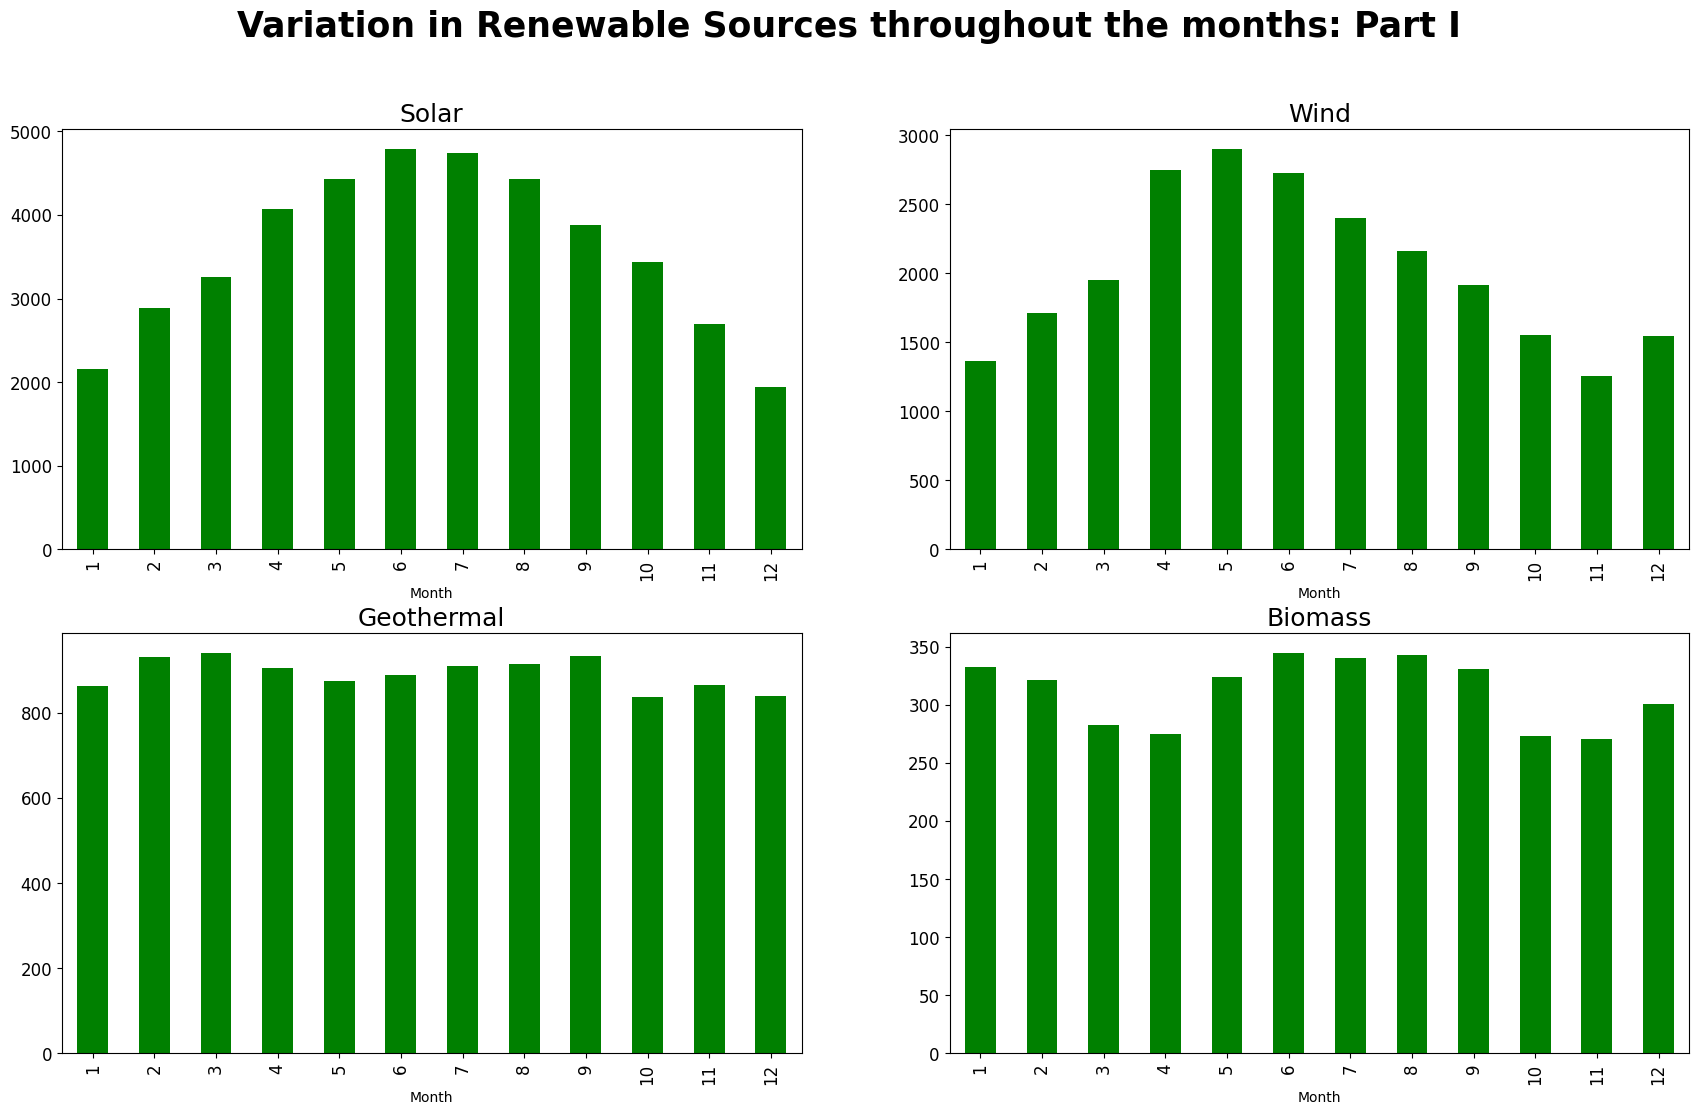

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(21, 12))

df_days.groupby(['Month'])["Solar"].mean().plot.bar(ax=ax[0][0], fontsize=12, color='green')
ax[0][0].set_title("Solar", fontsize=18)

df_days.groupby(['Month'])["Wind"].mean().plot.bar(ax=ax[0][1], fontsize=12, color='green')
ax[0][1].set_title("Wind", fontsize=18)

df_days.groupby(['Month'])["Geothermal"].mean().plot.bar(ax=ax[1][0], fontsize=12, color='green')
ax[1][0].set_title("Geothermal", fontsize=18)

df_days.groupby(['Month'])["Biomass"].mean().plot.bar(ax=ax[1][1], fontsize=12, color='green')
ax[1][1].set_title("Biomass", fontsize=18)

fig.suptitle('Variation in Renewable Sources throughout the months: Part I', fontsize=25, weight='bold')

Text(0.5, 0.98, 'Variation in Renewable Sources throughout the months: Part II')

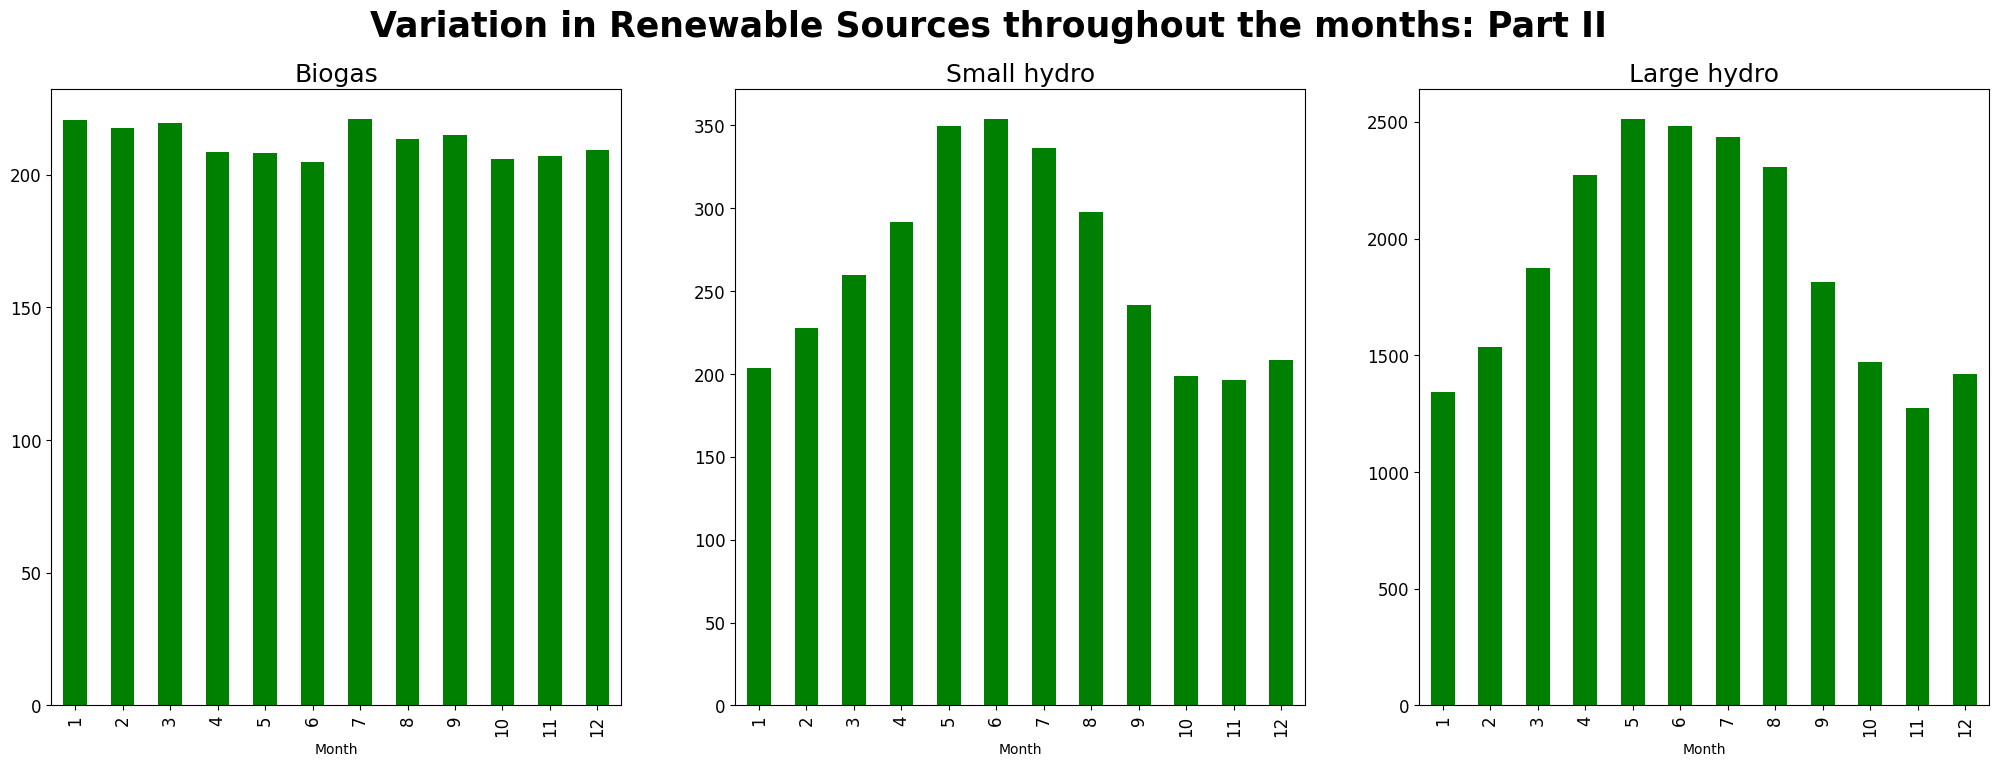

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))

df_days.groupby(['Month'])["Biogas"].mean().plot.bar(ax=ax[0], fontsize=12, color='green')
ax[0].set_title("Biogas", fontsize=18)

df_days.groupby(['Month'])["Small hydro"].mean().plot.bar(ax=ax[1], fontsize=12, color='green')
ax[1].set_title("Small hydro", fontsize=18)

df_days.groupby(['Month'])["Large hydro"].mean().plot.bar(ax=ax[2], fontsize=12, color='green')
ax[2].set_title("Large hydro", fontsize=18)

fig.suptitle('Variation in Renewable Sources throughout the months: Part II', fontsize=25, weight='bold')

Text(0.5, 0.98, 'Variation in Non-Renewable Sources throughout the months')

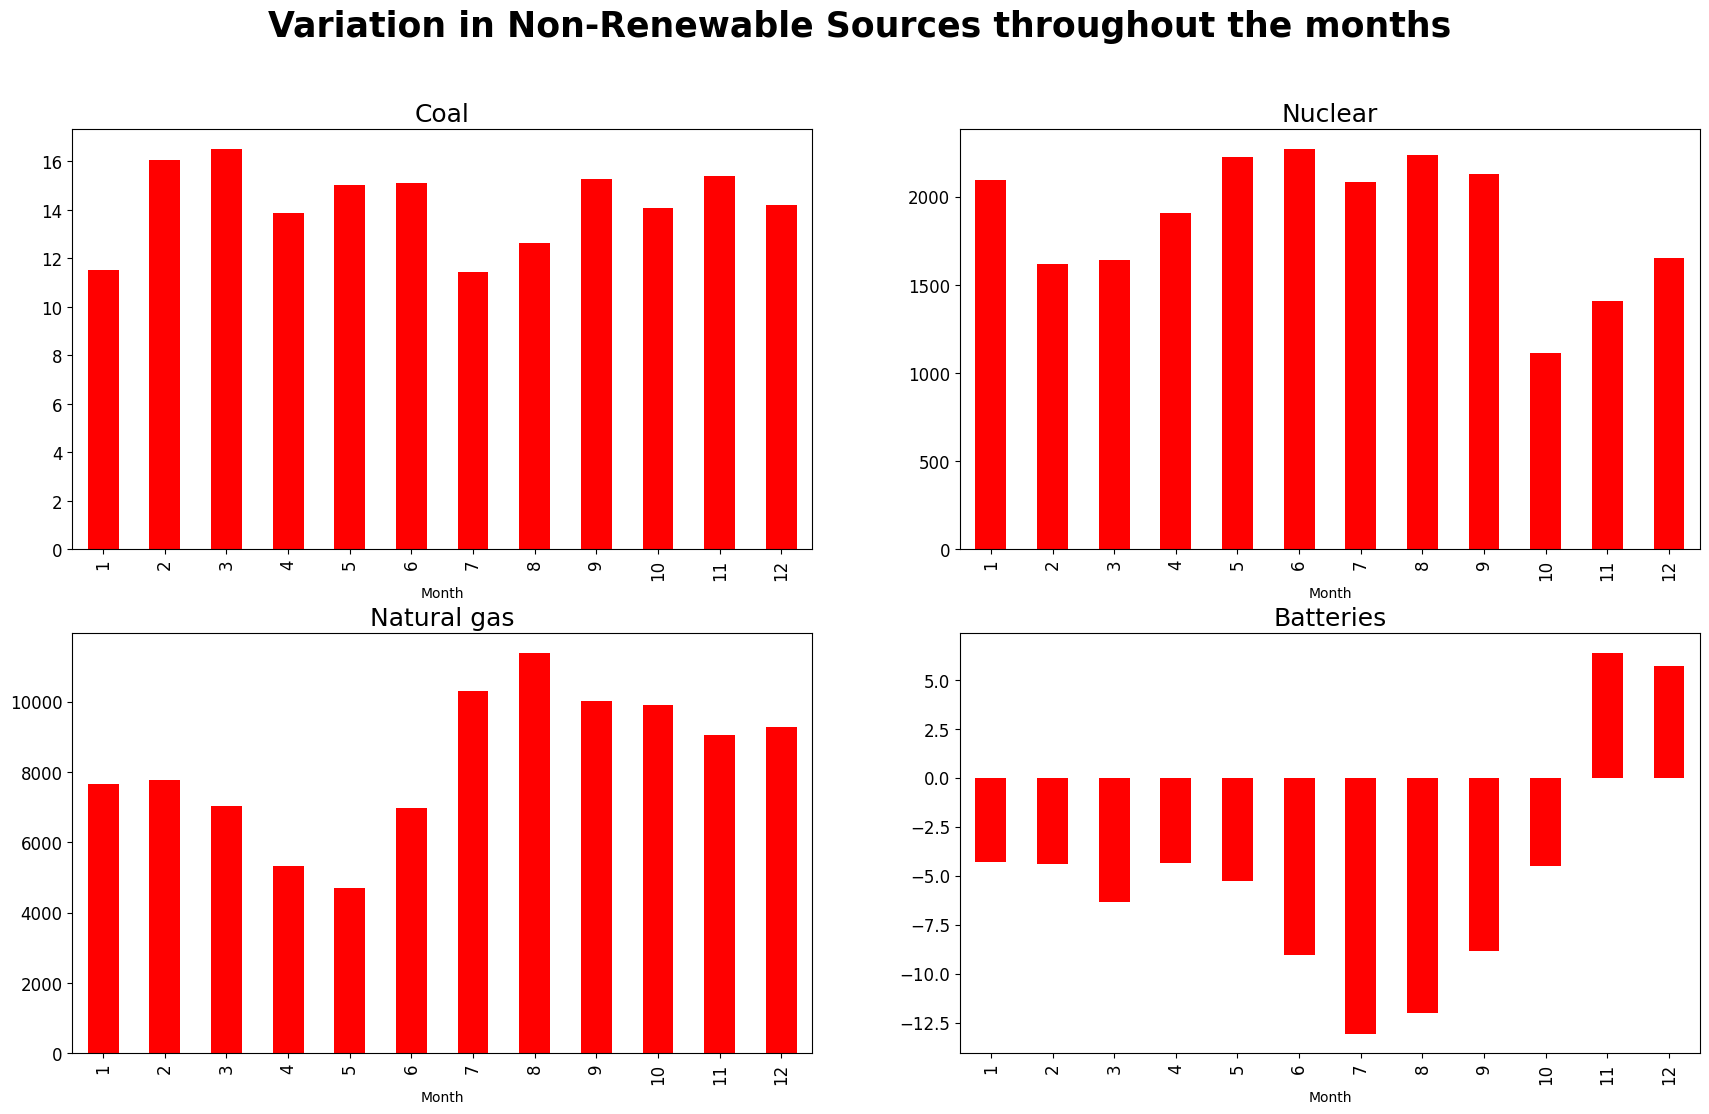

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(21, 12))

df_days.groupby(['Month'])["Coal"].mean().plot.bar(ax=ax[0][0], fontsize=12, color='red')
ax[0][0].set_title("Coal", fontsize=18)

df_days.groupby(['Month'])["Nuclear"].mean().plot.bar(ax=ax[0][1], fontsize=12, color='red')
ax[0][1].set_title("Nuclear", fontsize=18)

df_days.groupby(['Month'])["Natural gas"].mean().plot.bar(ax=ax[1][0], fontsize=12, color='red')
ax[1][0].set_title("Natural gas", fontsize=18)

df_days.groupby(['Month'])["Batteries"].mean().plot.bar(ax=ax[1][1], fontsize=12, color='red')
ax[1][1].set_title("Batteries", fontsize=18)

fig.suptitle('Variation in Non-Renewable Sources throughout the months', fontsize=25, weight='bold')

### A.4 Check what percentage occupies each source from the total

In [12]:
# Create new temporary dataframe for storing the average value of each source
src_cols = ['Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro', 'Coal', 'Nuclear', 
            'Natural gas', 'Large hydro', 'Batteries', 'Imports', 'Other', 'Total sources']

df = pd.DataFrame(df_days[src_cols].mean().round(2).sort_values(), columns=['Source'])
df = df.reset_index()

In [13]:
# Compute the percentage of each source from the total
percentage = []
for i in range(df.shape[0]):
    pct = (df.Source[i] / df.Source[13]) * 100
    percentage.append(round(pct, 2))
df['Percentage'] = percentage

df = df.drop(13) # Drop 'Total sources'
df = df.rename(columns = {'index':'Source', 'Source':'Amount'})

Text(0.5, 0.98, 'The percentage of each source')

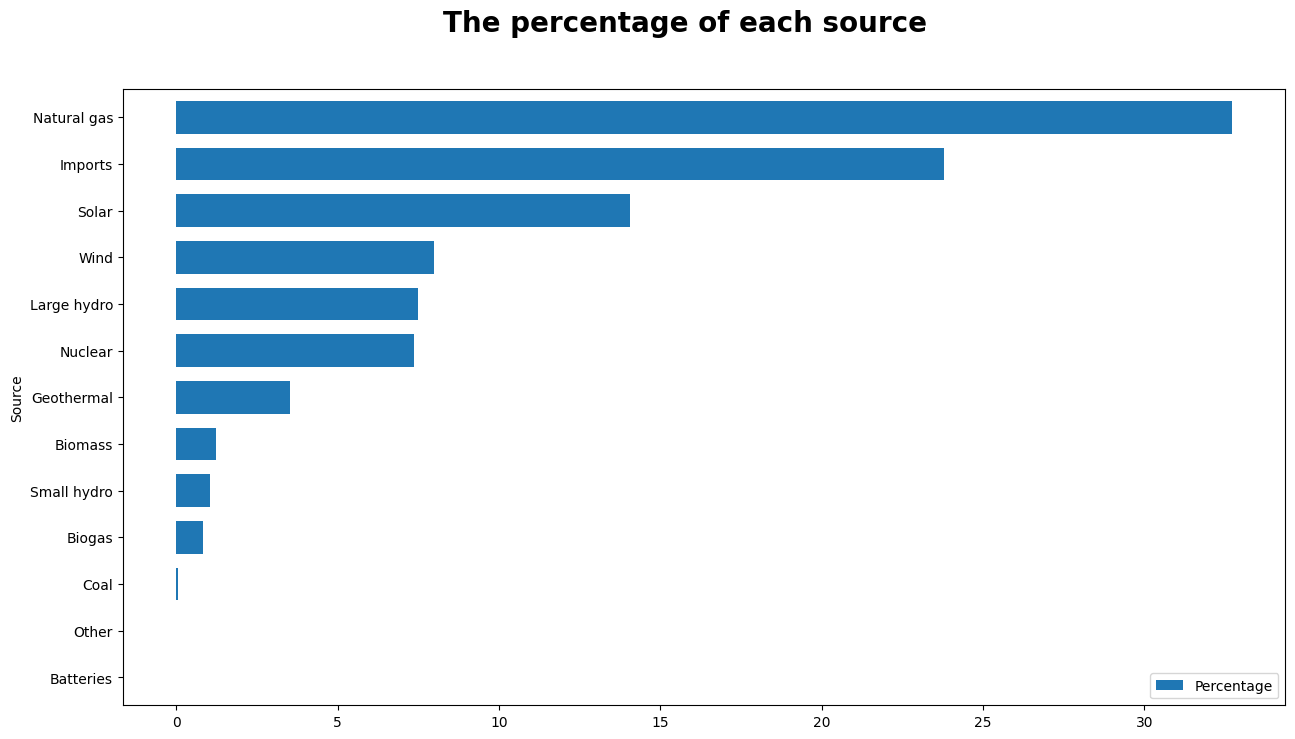

In [14]:
# Plotting a horizontal bar chart with the percentage of each source
fig, ax = plt.subplots(figsize=(15, 8))
df.plot.barh(x='Source', y='Percentage', width=0.7, ax=ax)
fig.suptitle('The percentage of each source', fontsize=20, weight='bold')

### A.5 Plot the variance of demand during a day

In [15]:
# Create new dataframe 'df_hours' for storing the average of each value at each time slot
df_hours = pd.DataFrame(columns = ['Day ahead forecast', 'Hour ahead forecast', 'Current demand', 'Solar',
                                   'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro', 'Coal', 'Nuclear',
                                   'Natural gas', 'Large hydro', 'Batteries', 'Imports', 'Other'])

time = dmnd_list[0]["Time"].copy()
for index, minute in enumerate(time): # Iterate every five minutes
    df_hours.loc[index] = np.nan
    for column in df_hours: # For each column in 'df_hours'
        total = 0
        for df in merged_list:
            if math.isnan(df[column].iloc[index]) == False:
                total += df[column].iloc[index]
        df_hours[column].loc[index] = (total / len(merged_list)).round(2) # Compute the average of each cell

df_hours["Total sources"] = df_hours.iloc[:,3:15].sum(axis=1)
df_hours["Time"] = time

df_hours.head() # Take a look at the 'df_hours' dataframe

,Day ahead forecast,Hour ahead forecast,Current demand,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Total sources,Time
0,24125.7,23352,23245.1,-14.81,2434.71,897.59,307.42,214.29,254.11,14.5,1866.93,8434.74,1873.89,-31.85,7368.89,0,23620.41,00:00
1,22744.5,23069,23178.6,-14.88,2432.65,897.69,307.3,214.3,252.95,14.68,1866.82,8387.37,1822.18,-3.15,7395.88,0,23573.79,00:05
2,22744.5,23069,23129.7,-14.93,2429.6,897.59,306.89,214.46,251.3,14.61,1866.72,8337.64,1797.71,-0.6,7412.36,0,23513.35,00:10
3,22744.5,23069,23029.9,-14.97,2425.59,897.77,306.71,214.6,250.3,14.51,1866.71,8287.09,1782.47,-6.29,7397.46,0,23421.95,00:15
4,22744.5,22785.3,22931,-14.99,2423.36,897.9,306.77,214.63,249.58,14.49,1866.71,8202.34,1774.99,-5.94,7401.56,0,23331.40,00:20


In [16]:
# Encode each time slot into a TimeOfDay label
# We consider four time zones:
# 1. Morning (05:00 - 12:00)
# 2. Afternoon (12:00 - 17:00)
# 3. Evening (17:00 - 21:00)
# 4. Night (21:00 - 05:00)

def encodeTime(time):
    x = time.split(":")
    if int(x[0]) in range(5, 12):
        return "1. Morning (05:00 - 12:00)"
    elif int(x[0]) in range(12, 17):
        return "2. Afternoon (12:00 - 17:00)"
    elif int(x[0]) in range(17, 21):
        return "3. Evening (17:00 - 21:00)"
    return "4. Night (21:00 - 05:00)"

df_hours["TimeOfDay"] = df_hours["Time"].apply(encodeTime)

df_hours.head() # Take a look at the 'df_hours' dataframe

,Day ahead forecast,Hour ahead forecast,Current demand,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Total sources,Time,TimeOfDay
0,24125.7,23352,23245.1,-14.81,2434.71,897.59,307.42,214.29,254.11,14.5,1866.93,8434.74,1873.89,-31.85,7368.89,0,23620.41,00:00,4. Night (21:00 - 05:00)
1,22744.5,23069,23178.6,-14.88,2432.65,897.69,307.3,214.3,252.95,14.68,1866.82,8387.37,1822.18,-3.15,7395.88,0,23573.79,00:05,4. Night (21:00 - 05:00)
2,22744.5,23069,23129.7,-14.93,2429.6,897.59,306.89,214.46,251.3,14.61,1866.72,8337.64,1797.71,-0.6,7412.36,0,23513.35,00:10,4. Night (21:00 - 05:00)
3,22744.5,23069,23029.9,-14.97,2425.59,897.77,306.71,214.6,250.3,14.51,1866.71,8287.09,1782.47,-6.29,7397.46,0,23421.95,00:15,4. Night (21:00 - 05:00)
4,22744.5,22785.3,22931,-14.99,2423.36,897.9,306.77,214.63,249.58,14.49,1866.71,8202.34,1774.99,-5.94,7401.56,0,23331.40,00:20,4. Night (21:00 - 05:00)


<AxesSubplot:xlabel='TimeOfDay'>

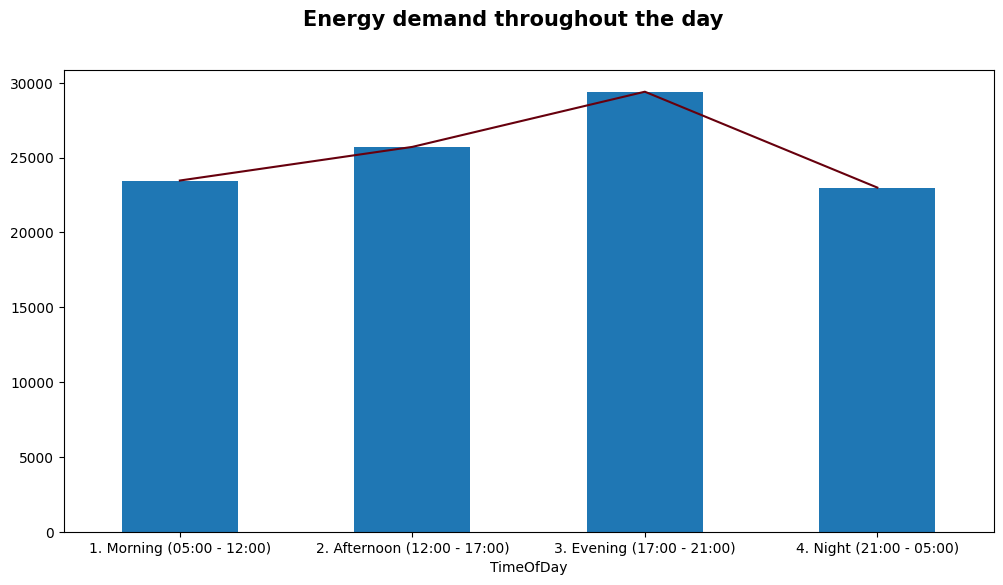

In [17]:
# Plotting a vertical bar chart with the variance of demand throughout the four time-zones of a day
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Energy demand throughout the day', fontsize=15, weight='bold')

df_hours["Current demand"] = df_hours["Current demand"].apply(pd.to_numeric)
df_hours.groupby(['TimeOfDay'])["Current demand"].mean().plot(kind='bar', ax=ax)
df_hours.groupby(['TimeOfDay'])["Current demand"].mean().plot(kind='line', ax=ax, colormap='Reds_r')

## Part B: Days clustering and detection of outliers

In [18]:
# Replace NaN values of 'df_days' with zeros
df_days = df_days.fillna(0)

### B.1 Perform clustering of days based on production

In [19]:
# Isolate only the sources columns from the 'df_days' dataframe
src_cols = ['Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro', 'Coal',
            'Nuclear', 'Natural gas', 'Large hydro', 'Batteries', 'Imports', 'Other']

array = df_days[src_cols].values # DBSCAN expects data in the form of an array/NumPy representation

In [20]:
# Linear dimensionality reduction to 2D using SVD of the data to project it to a lower dimensional space
array = PCA(n_components = 2).fit_transform(array)

In [21]:
stscaler = StandardScaler().fit(array) # Standardize the data
X = stscaler.transform(array)

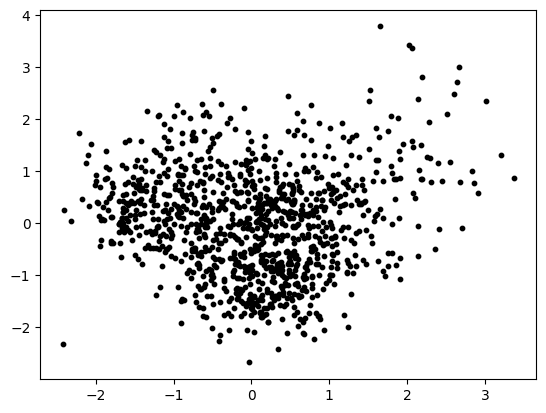

In [22]:
# Plot the data
plt.style.use("default")
plt.scatter(X[:,0], X[:,1], s=10, c="black")

In [23]:
# Calculate the distances of each point from its 3 neighbors (+1 including itself)
n_neighbors = 4
nn = NearestNeighbors(n_neighbors)
nn.fit(X)
distances, neighbors = nn.kneighbors(X)

# Sort the distances so we can take the distance from the third neighbor
distances = np.sort(distances[:, n_neighbors - 1], axis = 0)

Text(0.5, 1.0, 'Elbow Method for choosing eps')

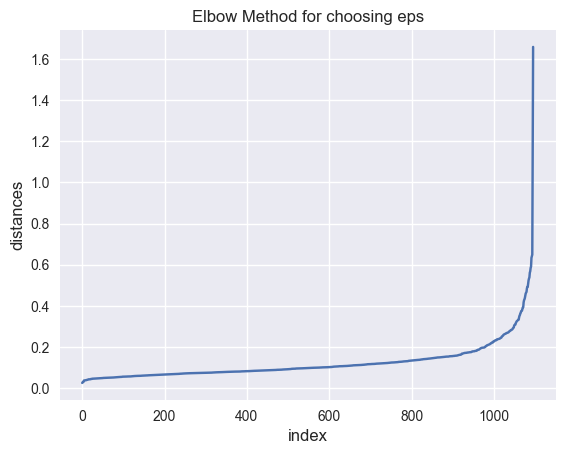

In [24]:
# Plot the distances
distances_df = pd.DataFrame({'distances': distances,
                           'index': list(range(0, len(distances)))})

plt.style.use("seaborn")
fig = plt.figure(figsize=(6.4, 4.8))
plt.plot(distances_df['index'], distances_df['distances'])
plt.xlabel("index", fontsize=12)
plt.ylabel("distances", fontsize=12)
plt.title(label='Elbow Method for choosing eps')

In [25]:
# Use KneeLocator to detect the knee (or elbow) point
kneedle = KneeLocator(np.arange(len(distances)), distances, S=1, curve='convex')
epsilon = distances[kneedle.knee]

In [26]:
# Perform DBSCAN clustering, using the optimal eps and min_samples -> 7
dbscan = DBSCAN(eps = epsilon, min_samples = 7)
dbscan.fit(X)

DBSCAN(eps=0.28332030513105155, min_samples=7)

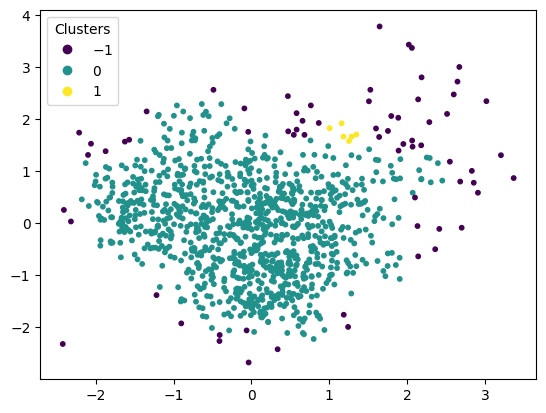

In [27]:
plt.style.use("default")
fig = plt.figure()
colors = dbscan.labels_

scatter = plt.scatter(X[:,0], X[:,1], s=10, c=colors)

# Produce a legend with the unique colors from the scatter
plt.legend(*scatter.legend_elements(), title="Clusters")

In [28]:
# Print the outlier production days
print(Counter(dbscan.labels_))
prod_outliers = df_days[dbscan.labels_ == -1]["Date"].tolist()

print("\nProduction outlier-days:\n")
for date in prod_outliers:
    print(date.strftime("%d-%m-%Y"))

Counter({0: 1023, -1: 67, 1: 6})

Production outlier-days:

02-01-2019
05-01-2019
12-01-2019
06-02-2019
26-03-2019
20-04-2019
04-05-2019
05-05-2019
06-05-2019
07-05-2019
26-05-2019
27-05-2019
29-07-2019
01-10-2019
03-12-2019
04-12-2019
25-01-2020
29-02-2020
30-07-2020
31-07-2020
03-08-2020
13-08-2020
14-08-2020
15-08-2020
17-08-2020
18-08-2020
19-08-2020
21-08-2020
22-08-2020
24-08-2020
05-09-2020
06-09-2020
01-10-2020
02-01-2021
23-01-2021
13-05-2021
14-05-2021
01-06-2021
02-06-2021
14-06-2021
16-06-2021
17-06-2021
18-06-2021
20-06-2021
21-06-2021
27-06-2021
28-06-2021
06-07-2021
08-07-2021
09-07-2021
10-07-2021
11-07-2021
12-07-2021
13-07-2021
27-07-2021
28-07-2021
29-07-2021
30-07-2021
31-07-2021
02-08-2021
03-08-2021
04-08-2021
12-08-2021
13-08-2021
07-09-2021
09-09-2021
23-12-2021


### B.2 Perform clustering of days based on demand

In [29]:
# Isolate only the demand columns from the 'df_days' dataframe in array/NumPy representation
array = df_days[['Day ahead forecast', 'Hour ahead forecast', 'Current demand']].values

In [30]:
# Linear dimensionality reduction to 2D using SVD of the data to project it to a lower dimensional space
array = PCA(n_components = 2).fit_transform(array)

In [31]:
stscaler = StandardScaler().fit(array) # Standardize the data
X = stscaler.transform(array)

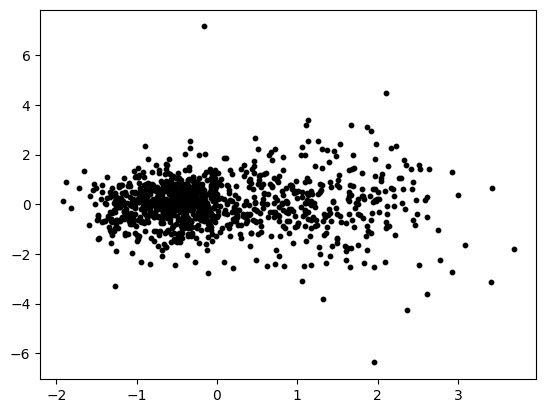

In [32]:
# Plot the data
plt.style.use("default")
plt.scatter(X[:,0], X[:,1], s=10, c="black")

In [33]:
# Calculate the distances of each point from its 3 neighbors (+1 including itself)
n_neighbors = 4
nn = NearestNeighbors(n_neighbors)
nn.fit(X)
distances, neighbors = nn.kneighbors(X)

# Sort the distances so we can take the distance from the third neighbor
distances = np.sort(distances[:, n_neighbors - 1], axis = 0)

Text(0.5, 1.0, 'Elbow Method for choosing eps')

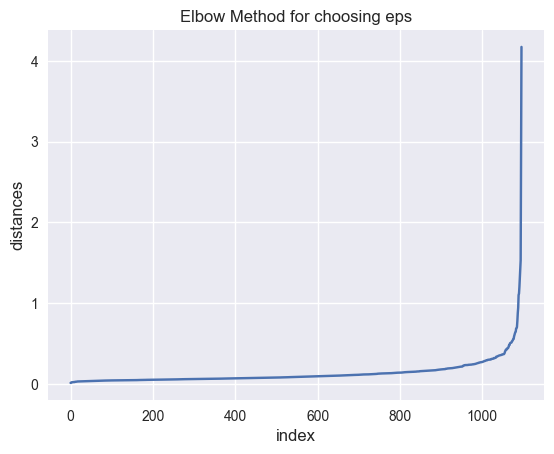

In [34]:
# Plot the distances
distances_df = pd.DataFrame({'distances': distances,
                           'index': list(range(0, len(distances)))})
plt.style.use("seaborn")
fig = plt.figure(figsize=(6.4, 4.8))
plt.plot(distances_df['index'], distances_df['distances'])
plt.xlabel("index", fontsize=12)
plt.ylabel("distances", fontsize=12)
plt.title(label='Elbow Method for choosing eps')

In [35]:
# Use KneeLocator to detect the knee (or elbow) point
kneedle = KneeLocator(np.arange(len(distances)), distances, S=1, curve='convex')
epsilon = distances[kneedle.knee]

In [36]:
# Perform DBSCAN clustering, using the optimal eps and min_samples -> 7
dbscan = DBSCAN(eps = epsilon, min_samples = 7)
dbscan.fit(X)

DBSCAN(eps=0.5107109194899248, min_samples=7)

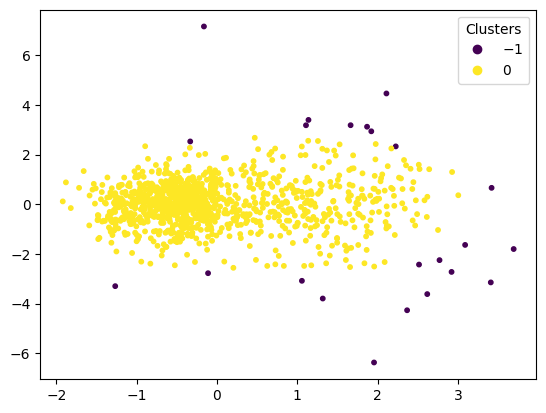

In [37]:
plt.style.use("default")
fig = plt.figure()
colors = dbscan.labels_

scatter = plt.scatter(X[:,0], X[:,1], c=colors, s=10)

# Produce a legend with the unique colors from the scatter
plt.legend(*scatter.legend_elements(), title="Clusters")

In [38]:
# Print the outlier production days
print(Counter(dbscan.labels_))
dmnd_outliers = df_days[dbscan.labels_ == -1]["Date"].tolist()

print("\nDemand outlier-days:\n")
for date in dmnd_outliers:
    print(date.strftime("%d-%m-%Y"))

Counter({0: 1073, -1: 23})

Demand outlier-days:

11-06-2019
13-06-2019
18-08-2019
09-10-2019
27-10-2019
10-06-2020
11-07-2020
01-08-2020
17-08-2020
18-08-2020
19-08-2020
20-08-2020
21-08-2020
22-08-2020
25-08-2020
26-08-2020
06-09-2020
07-09-2020
08-09-2020
18-09-2020
10-08-2021
07-09-2021
19-12-2021


In [39]:
# Print the days which are both ouliers in production and in demand
common = set(prod_outliers).intersection(dmnd_outliers)
for date in common:
    print(date.strftime("%d-%m-%Y"))

07-09-2021
17-08-2020
06-09-2020
22-08-2020
18-08-2020
19-08-2020
21-08-2020


### B.3 Perform clustering of days based on both production and demand

In [40]:
# Isolate the 'Current demand' and 'Total sources' columns from the 'df_days' dataframe in array/NumPy representation
array = df_days[['Current demand', 'Total sources']].values

In [41]:
stscaler = StandardScaler().fit(array) # Standardize the data
X = stscaler.transform(array)

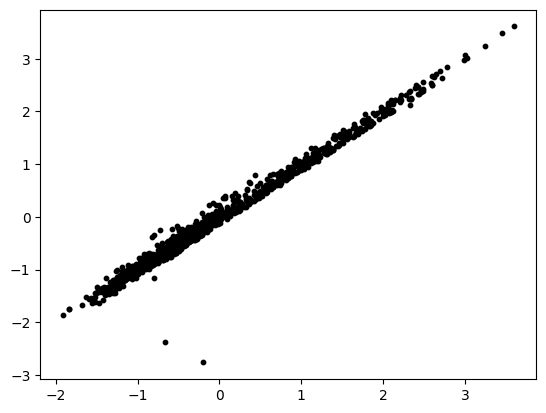

In [42]:
# Plot the data
plt.style.use("default")
plt.scatter(X[:,0], X[:,1], s=10, c="black")

In [43]:
# Calculate the distances of each point from its 3 neighbors (+1 including itself)
n_neighbors = 4
nn = NearestNeighbors(n_neighbors)
nn.fit(X)
distances, neighbors = nn.kneighbors(X)

# Sort the distances so we can take the distance from the third neighbor
distances = np.sort(distances[:, n_neighbors - 1], axis = 0)

Text(0.5, 1.0, 'Elbow Method for choosing eps')

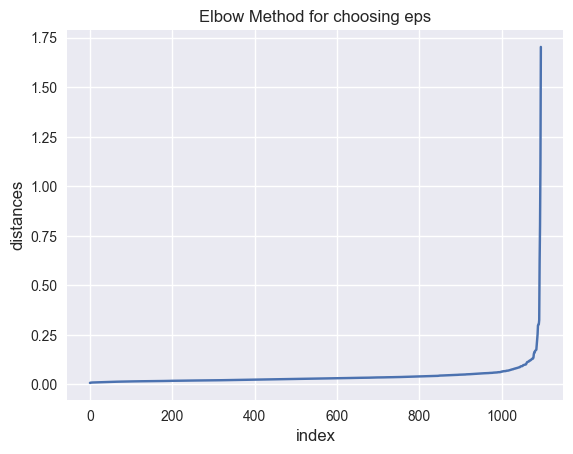

In [44]:
# Plot the distances
distances_df = pd.DataFrame({'distances': distances,
                           'index': list(range(0, len(distances)))})

plt.style.use("seaborn")
fig = plt.figure(figsize=(6.4, 4.8))
plt.plot(distances_df['index'], distances_df['distances'])
plt.xlabel("index", fontsize=12)
plt.ylabel("distances", fontsize=12)
plt.title(label='Elbow Method for choosing eps')

In [45]:
# Use KneeLocator to detect the knee (or elbow) point
kneedle = KneeLocator(np.arange(len(distances)), distances, S=1, curve='convex')
epsilon = distances[kneedle.knee]

In [46]:
# Perform DBSCAN clustering, using the optimal eps and min_samples -> 7
dbscan = DBSCAN(eps = epsilon, min_samples = 7)
dbscan.fit(X)

DBSCAN(eps=0.11978713897701107, min_samples=7)

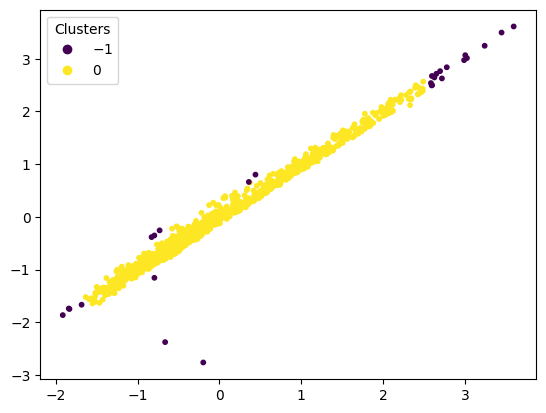

In [47]:
plt.style.use("default")
fig = plt.figure()
colors = dbscan.labels_

scatter = plt.scatter(X[:,0], X[:,1], c=colors, s=10)

# Produce a legend with the unique colors from the scatter
plt.legend(*scatter.legend_elements(), title="Clusters")

In [48]:
# Print the outlier production & demand days
print(Counter(dbscan.labels_))
both_outliers = df_days[dbscan.labels_ == -1]["Date"].tolist()

print("\nProduction-Demand outlier-days:\n")
for date in both_outliers:
    print(date.strftime("%d-%m-%Y"))

Counter({0: 1069, -1: 27})

Production-Demand outlier-days:

02-01-2019
13-03-2019
26-03-2019
24-07-2019
03-09-2019
04-09-2019
05-09-2019
29-03-2020
11-04-2020
12-04-2020
19-04-2020
14-08-2020
15-08-2020
16-08-2020
17-08-2020
18-08-2020
19-08-2020
20-08-2020
21-08-2020
24-08-2020
06-09-2020
09-07-2021
14-12-2021
15-12-2021
24-12-2021
25-12-2021
26-12-2021
